In [1]:
import pickle, os, numpy as np
from matplotlib import pyplot as plt

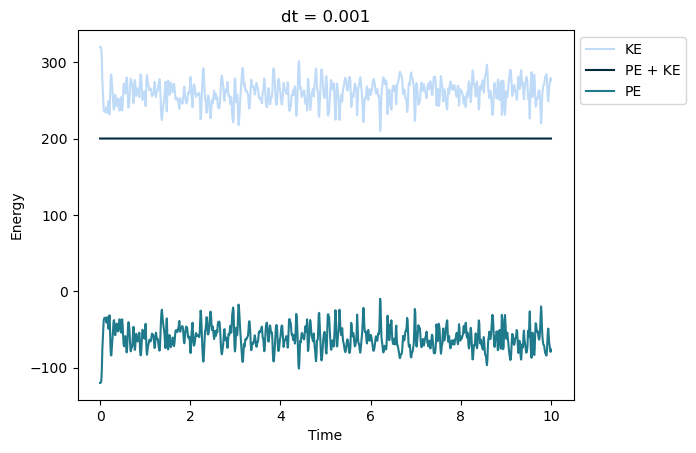

In [2]:
colors = ['#022b3a', '#1f7a8c', '#bfdbf7']

job_dir = f'./runs/N=64_totaltime=10_dt=10e-4'

with open(os.path.join(job_dir, 'data.pkl'), 'rb') as f:
    data = pickle.load(f)
time = data['time']
system_energy = data['system_energy']
system_pe = data['system_pe']
system_ke = data['system_ke']

plt.plot(time, system_ke, label = 'KE', color = colors[2])
plt.plot(time, system_energy, label = f'PE + KE', color = colors[0])
plt.plot(time, system_pe, label = 'PE', color = colors[1])

plt.title('dt = 0.001')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig('./ke_pe.png', bbox_inches='tight')
plt.show()

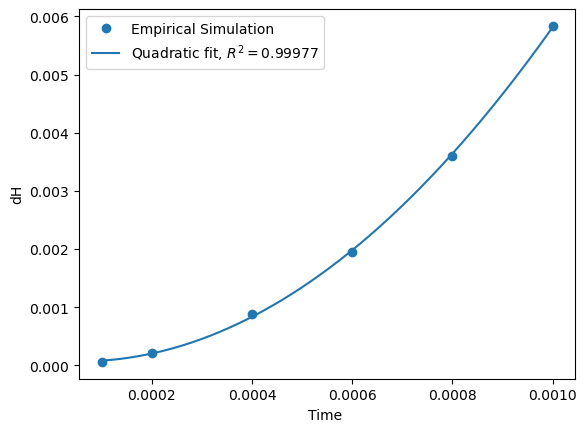

In [3]:
dH = []
dt = np.array([0.0001, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010])
for i in range(6):
    if i == 0:
        job_dir = f'./runs/N=64_totaltime=10_dt=1e-4'
    else:
        job_dir = f'./runs/N=64_totaltime=10_dt={i*2}e-4'
        
    with open(os.path.join(job_dir, 'data.pkl'), 'rb') as f:
        data = pickle.load(f)
    time = data['time']
    system_energy = data['system_energy']
    dH.append(system_energy.std())

dH = np.array(dH)
plt.plot(dt, dH, 'o', label='Empirical Simulation')
    
# Fit a quadratic polynomial: y = ax^2 + bx + c
coeffs = np.polyfit(dt, dH, deg=2)
poly = np.poly1d(coeffs)

dt_fit = np.linspace(dt.min(), dt.max(), 500)
dH_fit = poly(dt_fit)

# Plot the quadratic fit
dH_pred = poly(dt)
ss_res = np.sum((dH - dH_pred) ** 2)
ss_tot = np.sum((dH - np.mean(dH)) ** 2)
r_squared = 1 - (ss_res / ss_tot)
plt.plot(dt_fit, dH_fit, '-', label=rf'Quadratic fit, $R^2={r_squared:.5f}$', color = 'tab:blue')

plt.xlabel('Time ')
plt.ylabel('dH')
plt.legend()
plt.savefig('./quadratic_fit.png')
plt.show()

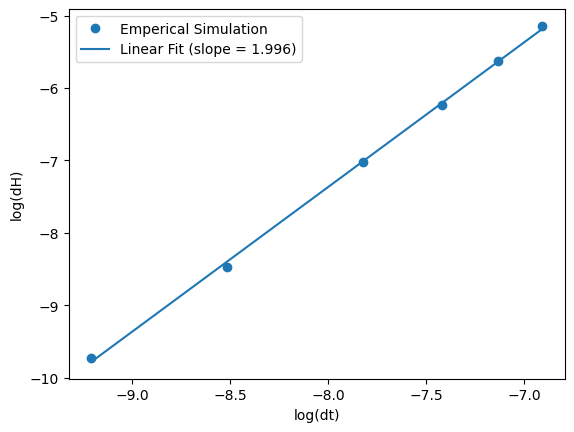

In [4]:
from scipy.stats import linregress

log_dH = np.log(dH)
log_dt = np.log(dt)

plt.plot(log_dt, log_dH, 'o', label='Emperical Simulation')
slope, intercept, r_value, p_value, std_err = linregress(log_dt, log_dH)
fit_line = slope * log_dt + intercept
plt.plot(log_dt, fit_line, '-', label=f'Linear Fit (slope = {slope:.3f})', color = 'tab:blue')

plt.xlabel('log(dt)')
plt.ylabel('log(dH)')
plt.legend()
plt.show()

(172.85915225210294, 7.7695935340937545)

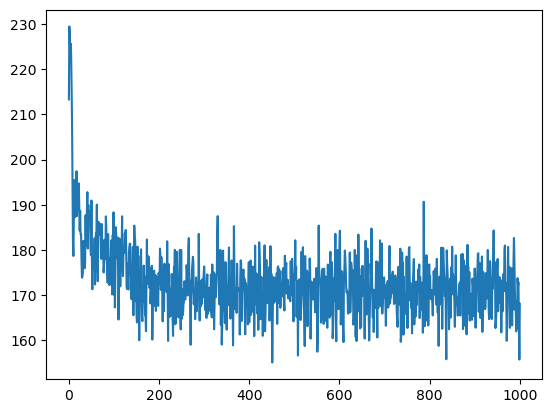

In [5]:
from src.utils import compute_pressure

p_means = []
p_stds = []
for N in [16, 25, 36, 49, 64, 81, 100]:
    job_dir = f'./runs/density_screens/N={N}'
    with open(os.path.join(job_dir, 'data.pkl'), 'rb') as f:
        data = pickle.load(f)

    masses = data['masses']
    r = data['r']
    v = data['v']
    potential = data['potential']
    unit_cell = data['unit_cell']

    p = np.array([compute_pressure(masses, r[t], v[t], potential, unit_cell) for t in range(len(r))])
    p_means.append(p.mean())
    p_stds.append(p.std())

plt.plot(range(len(r)), p,)
p.mean(), p.std()

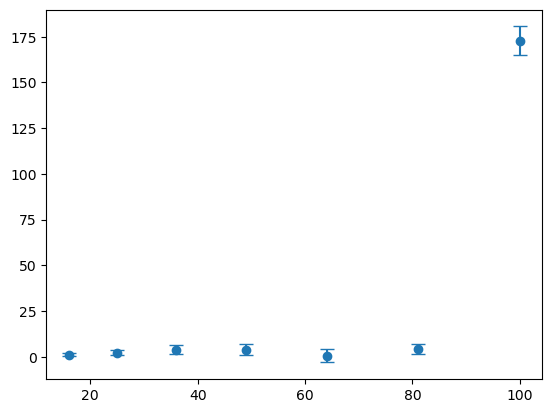

In [6]:
plt.errorbar([16, 25, 36, 49, 64, 81, 100], p_means, yerr = p_stds, fmt = 'o', capsize = 5)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


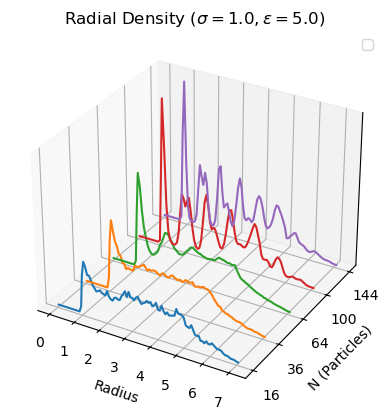

In [7]:
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plots
from src.utils import normalized_radial_density_function

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i, N in enumerate([16, 36, 64, 100, 144]):
    job_dir = f'./runs/density_screens/N={N}'
    with open(os.path.join(job_dir, 'data.pkl'), 'rb') as f:
        data = pickle.load(f)
    r = data['r'][800:1000] # Chooose 100 times points after the system is well equilibrated
    unit_cell = data['unit_cell']
    bin_centers, bin_heights = normalized_radial_density_function(r, unit_cell, num_bins=100)
    
    # Create an array with the same shape as bin_centers but filled with N (for y-axis)
    y = np.full_like(bin_centers, i)

    # Plot as a line in 3D
    ax.plot(bin_centers, y, bin_heights)

ax.set_zticks([])
ax.set_xlabel("Radius")
ax.set_ylabel("N (Particles)")
ax.set_yticks(range(5), [16, 36, 64, 100, 144])
ax.set_zlabel("Radial Density")

plt.title(r'Radial Density ($\sigma = 1.0, \epsilon = 5.0$)')
plt.legend()
plt.show()


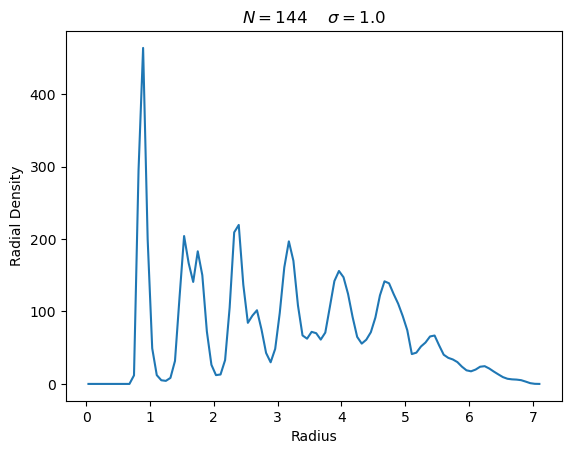

In [8]:
job_dir = f'./runs/density_screens/N={N}'
with open(os.path.join(job_dir, 'data.pkl'), 'rb') as f:
    data = pickle.load(f)
r = data['r'][800:1000] # Chooose 100 times points after the system is well equilibrated
unit_cell = data['unit_cell']
bin_centers, bin_heights = normalized_radial_density_function(r, unit_cell, num_bins=100)

plt.plot(bin_centers, bin_heights)
plt.title(r'$N = 144$    $\sigma = 1.0$')
plt.ylabel('Radial Density')
plt.yticks()
plt.xlabel('Radius')
plt.show()

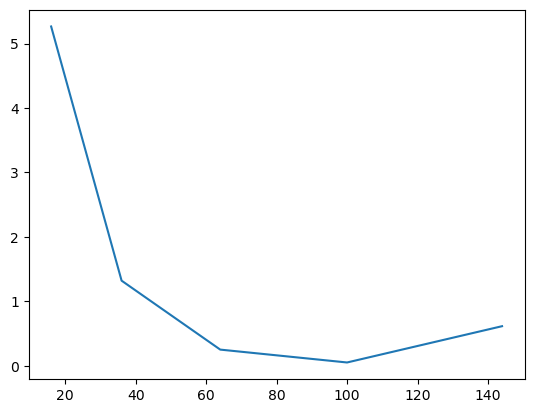

In [9]:
from src.utils import compute_diffusion_coeff_v

diffusion_coeffs = []
for N in[16, 36, 64, 100, 144]:
    job_dir = f'./runs/density_screens/N={N}'
    with open(os.path.join(job_dir, 'data.pkl'), 'rb') as f:
        data = pickle.load(f)

    v = data['v']
    time = data['time']
    
    diffusion_coeffs.append(compute_diffusion_coeff_v(v, time))

plt.plot([16, 36, 64, 100, 144], diffusion_coeffs)
plt.show()